In [1]:
from google.colab import files
uploaded = files.upload()

Saving TrashType_Image_Dataset.zip to TrashType_Image_Dataset.zip


In [2]:
import zipfile
import os

with zipfile.ZipFile("TrashType_Image_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("garbage_data")

os.listdir("garbage_data")

['__MACOSX', 'TrashType_Image_Dataset']

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "/content/garbage_data/TrashType_Image_Dataset"

img_height = 224
img_width = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


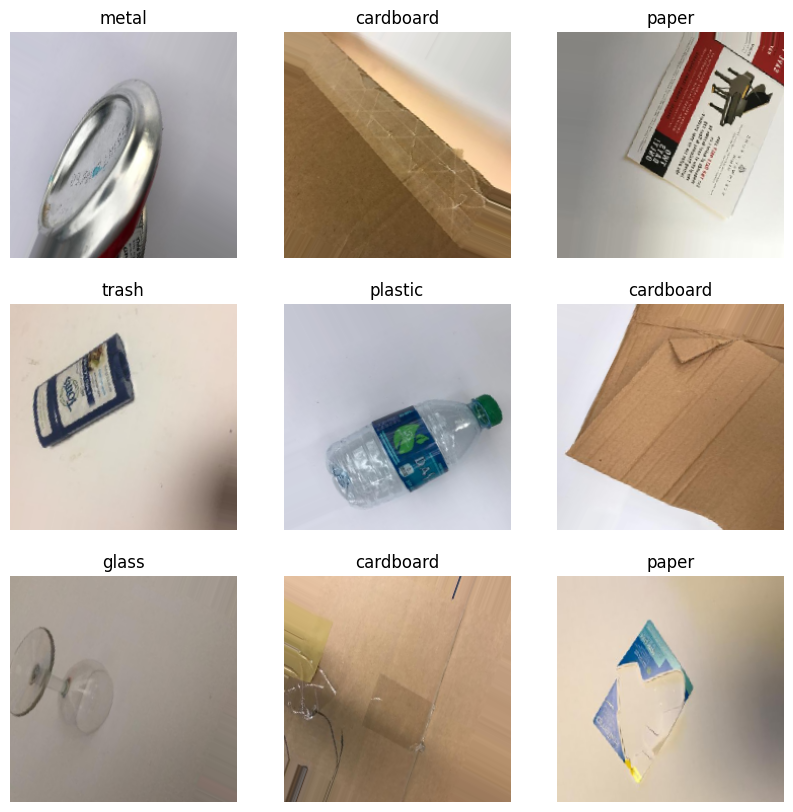

In [4]:
class_names = list(train_generator.class_indices.keys())

# Show a few images with labels
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - accuracy: 0.2314 - loss: 2.0371 - val_accuracy: 0.3797 - val_loss: 1.5244
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.3635 - loss: 1.5118 - val_accuracy: 0.5288 - val_loss: 1.2767
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.4675 - loss: 1.3324 - val_accuracy: 0.4930 - val_loss: 1.3065
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.4952 - loss: 1.2493 - val_accuracy: 0.5328 - val_loss: 1.1927
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.5398 - loss: 1.1775 - val_accuracy: 0.5785 - val_loss: 1.1451
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.5853 - loss: 1.1092 - val_accuracy: 0.5586 - val_loss: 1.1766
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.5713 - loss: 1.0849 - val_accuracy: 0.6501 - val_loss: 1.0215
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.6416 - loss: 0.9681 - val_accuracy: 0.6342 - v

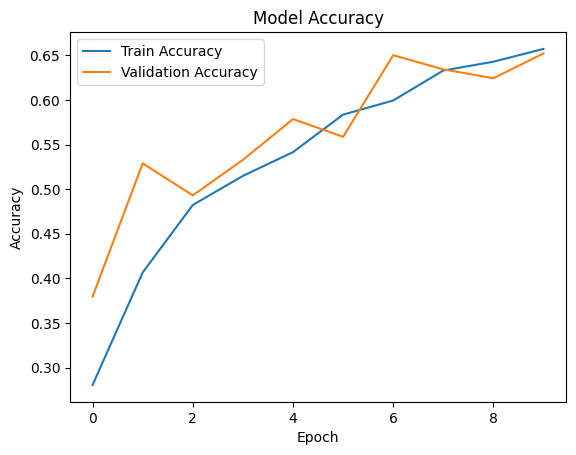

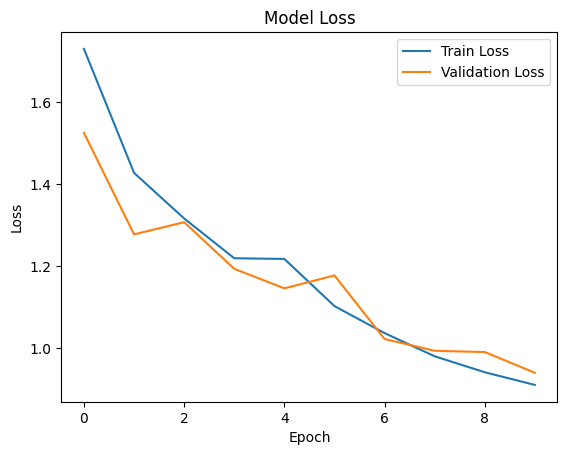

In [14]:
# Accuracy graph
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Loss graph
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/trash_013.jpg'

img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Predict
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Predicted class: trash


16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


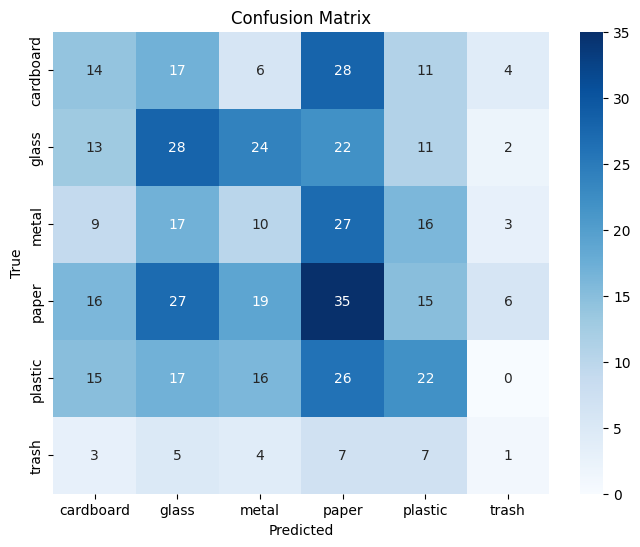

              precision    recall  f1-score   support

   cardboard       0.20      0.17      0.19        80
       glass       0.25      0.28      0.27       100
       metal       0.13      0.12      0.12        82
       paper       0.24      0.30      0.27       118
     plastic       0.27      0.23      0.25        96
       trash       0.06      0.04      0.05        27

    accuracy                           0.22       503
   macro avg       0.19      0.19      0.19       503
weighted avg       0.21      0.22      0.21       503



In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predicted labels from the validation set
val_generator.reset()
Y_pred = model.predict(val_generator, steps=val_generator.samples // val_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

model.save('garbage_classifier_model.h5')
